# Offside

## Description of the Reference Domain, and Objectives
The offside project starts from the idea of creating a recommendation system based on machine learning which, given a football player, returns a series of players as similar as possible to him based on a set of technical-tactical data. The reference domain is, obviously, the world of football, and the reference platform for data ingestion is Fbref, a consultation font that includes data relating to players, teams and championships

The solution approach that the project intends to adopt is based on a rather simple notion: let's assume we have a two-dimensional Cartesian plane, where each point corresponds to a player based on a pair of technical characteristics of our choice. The players most similar to the original player will be those who have the smallest distance on the Cartesian plane. It is sufficient to raise the plane to n dimensions, one for each of the technical attributes considered, to evaluate the similarity of the players on the hyperplane

In [35]:
import requests
import pandas as pd
import numpy

url= 'https://fbref.com/en/comps/11/stats/Serie-A-Stats'
df = pd.read_html(
    requests.get(url).text.replace('<!--','').replace('-->','')
    ,attrs={'id':'stats_standard'}
)[0]

# Definisci i nomi delle colonne desiderati
new_columns = ["(Background Information, Alphabetical Rank)", 
               "(Background Information, Full Name)", 
               "(Background Information, Nation)", 
               "(Background Information, Position)", 
               "(Background Information, Squad)", 
               "(Background Information, Age)", 
               "(Background Information, Year of Birth)",
               "(Playing Time, MP)",
               "(Playing Time, Starts)",
               "(Playing Time, Min)",
               "(Playing Time, 90s)",
               "(Performance, Gls)",
               "(Performance, Ast)",
               "(Performance, G+A)",
               "(Performance, G-PK)",
               "(Performance, PK)",
               "(Performance, PKatt)",
               "(Performance, CrdY)",
               "(Performance, CrdR)",
               "(Expected, xG)",
               "(Expected, npxG)",
               "(Expected, xAG)",
               "(Expected, npxG+xAG)",
               "(Progression, PrgC)",
               "(Progression, PrgP)",
               "(Progression, PrgR)",
               "(Per 90 Minutes, Gls)",
               "(Per 90 Minutes, Ast)",
               "(Per 90 Minutes, G+A)",
               "(Per 90 Minutes, G-PK)",
               "(Per 90 Minutes, G+A-PK)",
               "(Per 90 Minutes, xG)",
               "(Per 90 Minutes, xAG)",
               "(Per 90 Minutes, xG+xAG)",
               "(Per 90 Minutes, npxG)",
               "(Per 90 Minutes, npxG+xAG)"] + list(df.columns[36:])


# Assegna i nuovi nomi delle colonne
df.columns = new_columns



df["(Background Information, Full Name)"] = df["(Background Information, Full Name)"].astype("string")
df["(Background Information, Position)"] = df["(Background Information, Position)"].astype("category")
df["(Background Information, Squad)"] = df["(Background Information, Squad)"].astype("category")
df["(Background Information, Year of Birth)"] = pd.to_numeric(df["(Background Information, Year of Birth)"], errors='coerce')
df["(Playing Time, MP)"] = pd.to_numeric(df["(Playing Time, MP)"], errors='coerce')
df["(Playing Time, Starts)"] = pd.to_numeric(df["(Playing Time, Starts)"], errors='coerce')
df["(Playing Time, Min)"] = pd.to_numeric(df["(Playing Time, Min)"], errors='coerce')
df["(Playing Time, 90s)"] = pd.to_numeric(df["(Playing Time, 90s)"], errors='coerce')
df["(Performance, Gls)"] = pd.to_numeric(df["(Performance, Gls)"], errors='coerce')
df["(Performance, Ast)"] = pd.to_numeric(df["(Performance, Ast)"], errors='coerce')
df["(Performance, G+A)"] = pd.to_numeric(df["(Performance, G+A)"], errors='coerce')
df["(Performance, G-PK)"] = pd.to_numeric(df["(Performance, G-PK)"], errors='coerce')
df["(Performance, PK)"] = pd.to_numeric(df["(Performance, PK)"], errors='coerce')
df["(Performance, PKatt)"] = pd.to_numeric(df["(Performance, PKatt)"], errors='coerce')
df["(Performance, CrdY)"] = pd.to_numeric(df["(Performance, CrdY)"], errors='coerce')
df["(Performance, CrdR)"] = pd.to_numeric(df["(Performance, CrdR)"], errors='coerce')
df["(Expected, xG)"] = pd.to_numeric(df["(Expected, xG)"], errors='coerce')
df["(Expected, npxG)"] = pd.to_numeric(df["(Expected, npxG)"], errors='coerce')
df["(Expected, xAG)"] = pd.to_numeric(df["(Expected, xAG)"], errors='coerce')
df["(Expected, npxG+xAG)"] = pd.to_numeric(df["(Expected, npxG+xAG)"], errors='coerce')
df["(Progression, PrgC)"] = pd.to_numeric(df["(Progression, PrgC)"], errors='coerce')
df["(Progression, PrgP)"] = pd.to_numeric(df["(Progression, PrgP)"], errors='coerce')
df["(Progression, PrgR)"] = pd.to_numeric(df["(Progression, PrgR)"], errors='coerce')
df["(Per 90 Minutes, Gls)"] = pd.to_numeric(df["(Per 90 Minutes, Gls)"], errors='coerce')
df["(Per 90 Minutes, Ast)"] = pd.to_numeric(df["(Per 90 Minutes, Ast)"], errors='coerce')
df["(Per 90 Minutes, G+A)"] = pd.to_numeric(df["(Per 90 Minutes, G+A)"], errors='coerce')
df["(Per 90 Minutes, G-PK)"] = pd.to_numeric(df["(Per 90 Minutes, G-PK)"], errors='coerce')
df["(Per 90 Minutes, G+A-PK)"] = pd.to_numeric(df["(Per 90 Minutes, G+A-PK)"], errors='coerce')
df["(Per 90 Minutes, xG)"] = pd.to_numeric(df["(Per 90 Minutes, xG)"], errors='coerce')
df["(Per 90 Minutes, xAG)"] = pd.to_numeric(df["(Per 90 Minutes, xAG)"], errors='coerce')
df["(Per 90 Minutes, xG+xAG)"] = pd.to_numeric(df["(Per 90 Minutes, xG+xAG)"], errors='coerce')
df["(Per 90 Minutes, npxG)"] = pd.to_numeric(df["(Per 90 Minutes, npxG)"], errors='coerce')
df["(Per 90 Minutes, npxG+xAG)"] = pd.to_numeric(df["(Per 90 Minutes, npxG+xAG)"], errors='coerce')

# Rimuovo le Informazioni Inutili
df.drop('(Background Information, Alphabetical Rank)', axis=1, inplace=True)
df.drop('(Background Information, Squad)', axis=1, inplace=True)
df.drop('(Background Information, Nation)', axis=1, inplace=True)
df.drop('(Background Information, Age)', axis=1, inplace=True)
df.drop(df.columns[len(df.columns)-1], axis=1, inplace=True)


df.to_csv("serieA.csv", encoding='utf-8', index=False)

df

,"(Background Information, Full Name)","(Background Information, Position)","(Background Information, Year of Birth)","(Playing Time, MP)","(Playing Time, Starts)","(Playing Time, Min)","(Playing Time, 90s)","(Performance, Gls)","(Performance, Ast)","(Performance, G+A)",...,"(Per 90 Minutes, Gls)","(Per 90 Minutes, Ast)","(Per 90 Minutes, G+A)","(Per 90 Minutes, G-PK)","(Per 90 Minutes, G+A-PK)","(Per 90 Minutes, xG)","(Per 90 Minutes, xAG)","(Per 90 Minutes, xG+xAG)","(Per 90 Minutes, npxG)","(Per 90 Minutes, npxG+xAG)"
0,Francesco Acerbi,DF,1988.0,20.0,18.0,1642.0,18.2,2.0,1.0,3.0,...,0.11,0.05,0.16,0.11,0.16,0.06,0.09,0.15,0.06,0.15
1,Yacine Adli,MF,2000.0,16.0,12.0,994.0,11.0,1.0,0.0,1.0,...,0.09,0.00,0.09,0.09,0.09,0.03,0.04,0.07,0.03,0.07
2,Michel Aebischer,MF,1997.0,25.0,17.0,1457.0,16.2,0.0,1.0,1.0,...,0.00,0.06,0.06,0.00,0.06,0.03,0.07,0.10,0.03,0.10
3,Lucien Agoume,MF,2002.0,1.0,0.0,5.0,0.1,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,Marley Aké,FW,2001.0,1.0,0.0,10.0,0.1,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,Nadir Zortea,DF,1999.0,5.0,0.0,149.0,1.7,1.0,0.0,1.0,...,0.60,0.00,0.60,0.60,0.60,0.05,0.16,0.21,0.05,0.21
606,Szymon Żurkowski,MF,1997.0,6.0,5.0,451.0,5.0,4.0,0.0,4.0,...,0.80,0.00,0.80,0.80,0.80,0.14,0.02,0.16,0.14,0.16
607,Milan Đurić,FW,1990.0,20.0,13.0,1204.0,13.4,5.0,1.0,6.0,...,0.37,0.07,0.45,0.30,0.37,0.34,0.09,0.43,0.16,0.25
608,Milan Đurić,FW,1990.0,5.0,3.0,307.0,3.4,0.0,1.0,1.0,...,0.00,0.29,0.29,0.00,0.29,0.15,0.17,0.33,0.15,0.33


# Dataset Columns Explanation

The dataset comprises 37 columns providing comprehensive insights into various aspects of player performance in a football context. Here's a detailed breakdown of each column:

1. **Rk (Rank):** This column denotes the ranking of the rows from top to bottom, recalculated after sorting a column. 🔴
   
2. **Nation (Nationality):** Indicates the nationality of the player, primarily sourced from international senior and youth play records, Wikipedia citizenship information, or birthplace data. 🔴
   
3. **Pos (Position):** Specifies the position most frequently played by the player.
   
4. **Age:** Represents the current age of the player at the start of the season, with specific dates for winter and summer leagues. 🔴
   
5. **Born:** Year of birth of the player. 
   
6. **MP (Matches Played):** Indicates the total number of matches played by the player or squad.
   
7. **Starts:** Denotes the number of games started by the player.
   
8. **Min (Minutes Played):** Total minutes played by the player.
   
9. **90s (90s Played):** Minutes played divided by 90, providing a standard measure of performance.
   
10. **Gls (Goals):** Total goals scored or allowed.
   
11. **Ast (Assists):** Total assists provided by the player.
   
12. **G+A (Goals + Assists):** Combined goals and assists tally.
   
13. **G-PK (Non-Penalty Goals):** Goals excluding penalty kicks.
   
14. **PK (Penalty Kicks Made):** Number of penalty kicks successfully converted.
   
15. **PKatt (Penalty Kicks Attempted):** Total number of penalty kicks attempted.
   
16. **CrdY (Yellow Cards):** Number of yellow cards received.
   
17. **CrdR (Red Cards):** Number of red cards received.
   
18. **xG (Expected Goals):** Expected goals calculated by Opta, including penalty kicks but excluding penalty shootouts.
   
19. **npxG (Non-Penalty Expected Goals):** Expected goals excluding penalty kicks, provided by Opta.
   
20. **xAG (Exp. Assisted Goals):** Expected goals following a pass that assists a shot, provided by Opta.
   
21. **npxG+xAG (Non-Penalty xG + Exp. Assisted Goals):** Sum of non-penalty expected goals and expected assisted goals.
   
22. **PrgC (Progressive Carries):** Carries advancing the ball towards the opponent's goal line, excluding those ending in the defensive half.
   
23. **PrgP (Progressive Passes):** Completed passes advancing the ball towards the opponent's goal line.
   
24. **PrgR (Progressive Passes Received):** Completed passes received that advance the ball towards the opponent's goal line.
   
25. **Gls/90 (Goals per 90):** Goals scored per 90 minutes played, requiring a minimum of 30 minutes played per squad game.
   
26. **Ast/90 (Assists per 90):** Assists provided per 90 minutes played, with the same minimum playtime requirement.
   
27. **G+A/90 (Goals + Assists per 90):** Combined goals and assists per 90 minutes played.
   
28. **G-PK/90 (Non-Penalty Goals per 90):** Goals excluding penalty kicks per 90 minutes played.
   
29. **G+A-PK/90 (Non-Penalty Goals + Assists per 90):** Combined goals and assists excluding penalty kicks per 90 minutes played.
   
30. **xG/90 (Expected Goals per 90):** Expected goals per 90 minutes played, including penalty kicks but excluding penalty shootouts.
   
31. **xAG/90 (Expected Assisted Goals per 90):** Expected assisted goals per 90 minutes played.
   
32. **xG+xAG/90 (Expected Goals + Assisted Goals per 90):** Combined expected goals and assisted goals per 90 minutes played.
   
33. **npxG/90 (Non-Penalty Expected Goals per 90):** Non-penalty expected goals per 90 minutes played.
   
34. **npxG+xAG/90 (Non-Penalty xG + Exp. Assisted Goals per 90):** Combined non-penalty expected goals and expected assisted goals per 90 minutes played.
   
35. **Leadership Qualification:** Minimum 30 minutes played per squad game required for leadership statistics.
   
36. **Matches:** An hyperlink to the player's matches 🔴

In [81]:
import pandas as pd
from scipy.spatial.distance import euclidean

# Assume df è il tuo DataFrame contenente i dati dei calciatori

df.dropna(inplace=True)
relevant_cols = ["(Background Information, Position)", 
               "(Background Information, Year of Birth)",
               "(Playing Time, MP)",
               "(Playing Time, Starts)",
               "(Playing Time, Min)",
               "(Playing Time, 90s)",
               "(Performance, Gls)",
               "(Performance, Ast)",
               "(Performance, G+A)",
               "(Performance, G-PK)",
               "(Performance, PK)",
               "(Performance, PKatt)",
               "(Performance, CrdY)",
               "(Performance, CrdR)",
               "(Expected, xG)",
               "(Expected, npxG)",
               "(Expected, xAG)",
               "(Expected, npxG+xAG)",
               "(Progression, PrgC)",
               "(Progression, PrgP)",
               "(Progression, PrgR)",
               "(Per 90 Minutes, Gls)",
               "(Per 90 Minutes, Ast)",
               "(Per 90 Minutes, G+A)",
               "(Per 90 Minutes, G-PK)",
               "(Per 90 Minutes, G+A-PK)",
               "(Per 90 Minutes, xG)",
               "(Per 90 Minutes, xAG)",
               "(Per 90 Minutes, xG+xAG)",
               "(Per 90 Minutes, npxG)",
               "(Per 90 Minutes, npxG+xAG)"]  # Definisci le colonne rilevanti
numeric_cols = df[relevant_cols].select_dtypes(include=['number'])

# Normalizza i dati
normalized_df = (numeric_cols - numeric_cols.mean()) / numeric_cols.std()

# Specifica il nome del giocatore di riferimento
reference_player_name = "Mike Maignan"

# Trova l'indice della riga corrispondente al giocatore di riferimento
reference_player_index = df.index[df['(Background Information, Full Name)'] == reference_player_name][0]

distances = {}
reference_player = normalized_df.loc[reference_player_index]

for i, player in normalized_df.iterrows():
    if i == reference_player_index:
        continue
    distances[i] = euclidean(reference_player, player)

sorted_distances = sorted(distances.items(), key=lambda x: x[1])

top_5_similar_players = sorted_distances[:5]

print(f"Il Giocatore di Riferimento è {reference_player_name}\n")

for player_index, distance in top_5_similar_players:
    player_name = df.loc[player_index]['(Background Information, Full Name)']
    print(f"Giocatore: {player_name}, Distanza: {distance}")


Il Giocatore di Riferimento è Mike Maignan

Giocatore: Sardar Azmoun, Distanza: 0.0
Giocatore: Jaime Báez, Distanza: 0.0
Giocatore: Dylan Bronn, Distanza: 0.0
Giocatore: Samu Castillejo, Distanza: 0.0
Giocatore: Patrick Ciurria, Distanza: 0.0


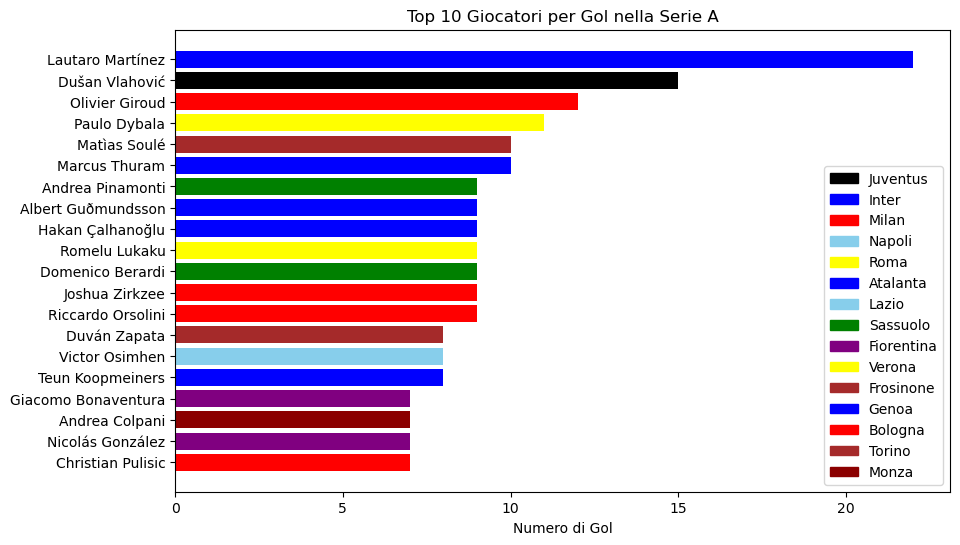

In [16]:
import matplotlib.pyplot as plt

# Definisci una mappatura di colori per ciascuna squadra
colors = {'Juventus': 'black', 'Inter': 'blue', 'Milan': 'red', 'Napoli': 'skyblue', 'Roma': 'yellow', 
          'Atalanta': 'blue', 'Lazio': 'skyblue', 'Sassuolo': 'green', 'Fiorentina': 'purple', 'Verona': 'yellow', 'Frosinone': 'brown', 'Genoa': 'blue', 'Bologna': 'red', 'Torino': 'brown', 'Monza': 'darkred'}

# Ordina il DataFrame per il numero di gol
df_sorted = df.sort_values(by='(Performance, Gls)', ascending=False).head(20)

# Plot
plt.figure(figsize=(10,6))
bars = plt.barh(df_sorted['(Background Information, Full Name)'], df_sorted['(Performance, Gls)'], 
                color=[colors[squad] for squad in df_sorted['(Background Information, Squad)']])
plt.xlabel('Numero di Gol')
plt.title('Top 10 Giocatori per Gol nella Serie A')
plt.gca().invert_yaxis()

# Aggiungi legenda per le squadre
legend_colors = [plt.Rectangle((0,0),1,1, color=color) for color in colors.values()]
plt.legend(legend_colors, colors.keys())

plt.show()

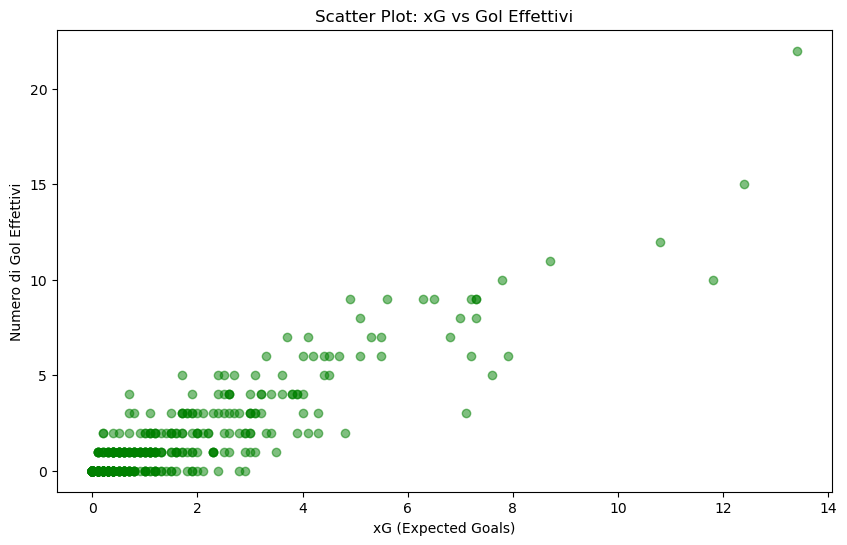

In [3]:
plt.figure(figsize=(10,6))
plt.scatter(df['(Expected, xG)'], df['(Performance, Gls)'], color='green', alpha=0.5)
plt.xlabel('xG (Expected Goals)')
plt.ylabel('Numero di Gol Effettivi')
plt.title('Scatter Plot: xG vs Gol Effettivi')
plt.show()


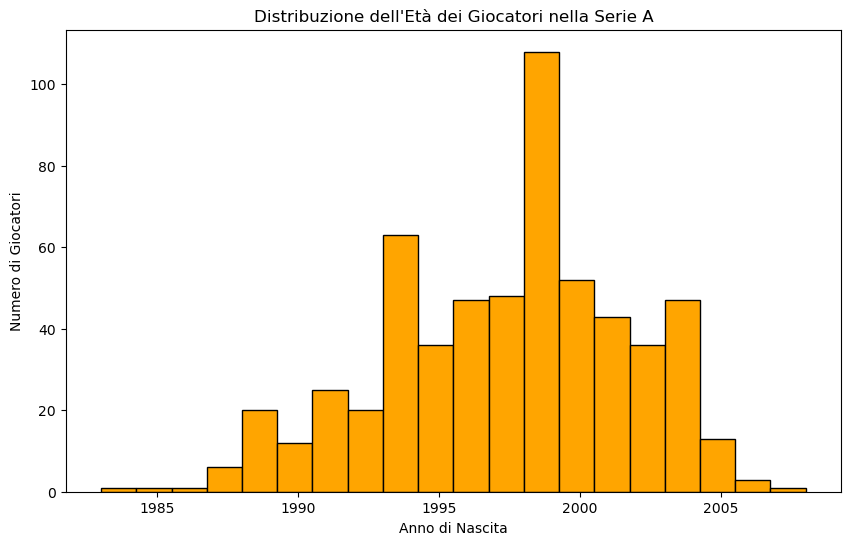

In [4]:
plt.figure(figsize=(10,6))
plt.hist(df['(Background Information, Year of Birth)'], bins=20, color='orange', edgecolor='black')
plt.xlabel('Anno di Nascita')
plt.ylabel('Numero di Giocatori')
plt.title('Distribuzione dell\'Età dei Giocatori nella Serie A')
plt.show()
